In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
mdist = read_tsv("distances.tsv.xz", col_names = c("fq1", "fq2", "dist", "pval", "shared"))

Rows: 827541 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): fq1, fq2, shared
dbl (2): dist, pval

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
dntax = read_csv("https://github.com/borevitzlab/cca-eucs/raw/master/metadata/originals/DNTaxonomyCleaned.csv")

Rows: 1159 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Binomial, Genus, Subgenus, Section, Series, Subseries, Species, Sub...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [110]:
spp = read_tsv("../alleuc_sample_metadata.tsv") %>%
    select(sample, species) %>%
    left_join(
        dntax %>% select(Binomial, Section),
        by=join_by(species==Binomial)
    ) %>%
    mutate(species2=sub(" subsp.*", "", species))

Rows: 3836 Columns: 15
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (10): sample, project, species, datum, location, collectors, population...
dbl   (4): latitude, longitude, elevation, percent_dieback
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [111]:
str(spp)

tibble [3,836 × 4] (S3: tbl_df/tbl/data.frame)
 $ sample  : chr [1:3836] "Acacia_acuminata_ANBG" "Acacia_dealbata" "Acacia_melanoxylon" "FDK10" ...
 $ species : chr [1:3836] NA NA NA "Eucalyptus microcarpa" ...
 $ Section : chr [1:3836] NA NA NA "Adnataria" ...
 $ species2: chr [1:3836] NA NA NA "Eucalyptus microcarpa" ...


In [112]:
meta = read_tsv("dieback_only.tsv")
meta = meta %>% 
    filter(
        !grepl("^NCT", sample),
        !if_all(read1:interleaved, is.na),
    ) %>%
    select(sample) %>%
    left_join(spp, by=join_by(sample))

Rows: 1444 Columns: 5
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): library, sample, read1, read2, interleaved

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in left_join(., spp, by = join_by(sample)):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 6 of `x` matches multiple rows in `y`.
ℹ Row 176 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [113]:
fdist = mdist %>%
    transmute(
        samp1 = sub("tmp/(.+).fastq.gz", "\\1", fq1),
        samp2 = sub("tmp/(.+).fastq.gz", "\\1", fq2),
        dist=dist,
    )

In [168]:
distdendro = function(df, key) {
    dmat = bind_rows(fdist, rename(fdist, samp2=samp1, samp1=samp2)) %>%
        filter(samp1 %in% df$sample, samp2%in%df$sample) %>%
        group_by(samp1, samp2) %>%
        summarise(dist=mean(dist)) %>%
        ungroup() %>%
        pivot_wider(names_from = "samp2", values_from = "dist") %>%
        column_to_rownames("samp1") %>%
        as.matrix()
    dmat[is.na(dmat)] = 0
    
    hc =dmat %>%
        as.dist() %>%
        hclust()
    
    df = select(spp, sample, species2) %>%
        unique() %>%
        column_to_rownames("sample")
    p = ggtree(hc, layout="circular")  %<+% spp 
    gheatmap(p, df, colnames=F, offset=0, width=.3) +
        scale_y_continuous(expand=c(0, 0.6)) +
        scale_fill_brewer(palette="Set1") +
        labs(fill="Species", title=key)
    ggsave(sprintf("plot/mashtree_%s.png", key), width=3200, height=2400, units = "px")
    
    meand = dmat %>%
        rowMeans()
    m = meand<0.06
    hist(meand)
    
    dfilt = dmat[m, m]
    png(sprintf("plot/mashmatrix_%s.png", key), width=2400, height=2400)
    image(dmat)
    dev.off()
    dfilt %>%
        as.dist() %>%
        prcomp() %>%
        magrittr::extract2("x") %>%
        as.data.frame() %>%
        rownames_to_column("sample") %>%
        left_join(spp) %>%
        ggplot(aes(x=PC1, y=PC2)) +
        geom_point(aes(colour=species2), size=4, alpha=0.5) +
        labs(colour="Species", title=key) +
        guides(colour=guide_legend(nrow=2)) +
        scale_color_brewer(palette = "Set1") +
        theme_bw() +
        theme(
            legend.position="bottom",
        )
    ggsave(sprintf("plot/mashpca_%s.png", key), width=2400, height=2400, units = "px")
    dmat
}

`summarise()` has grouped output by 'samp1'. You can override using the `.groups` argument.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Joining with `by = join_by(sample)`
`summarise()` has grouped output by 'samp1'. You can override using the `.groups` argument.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Joining with `by = join_by(sample)`
`summarise()` has grouped output by 'samp1'. You can override using the `.groups` argument.
Scale for y is already present.
Adding another

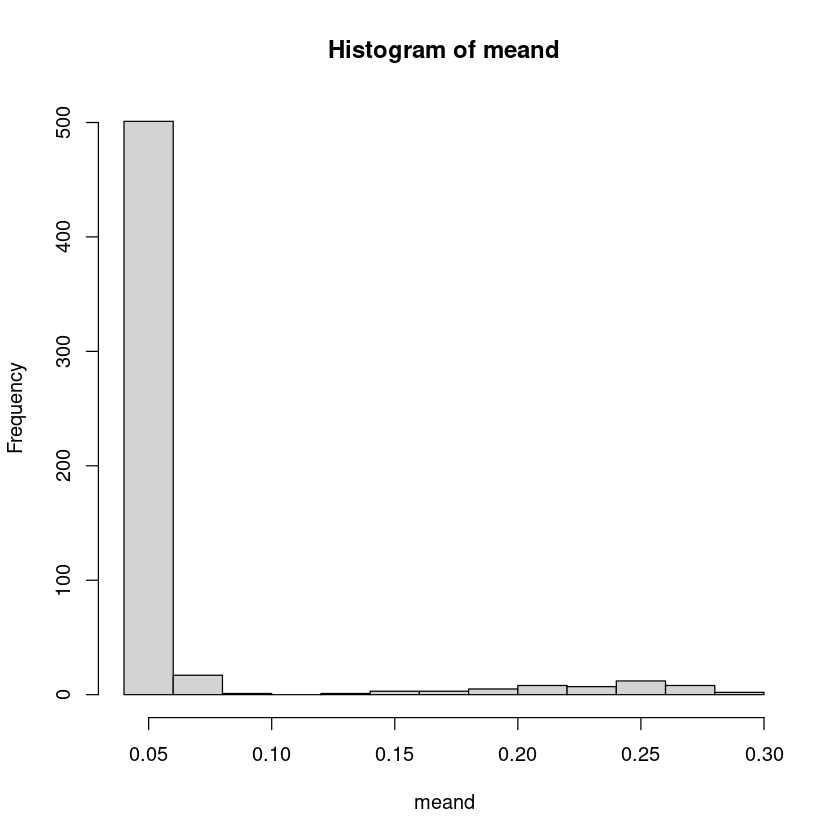

Joining with `by = join_by(sample)`


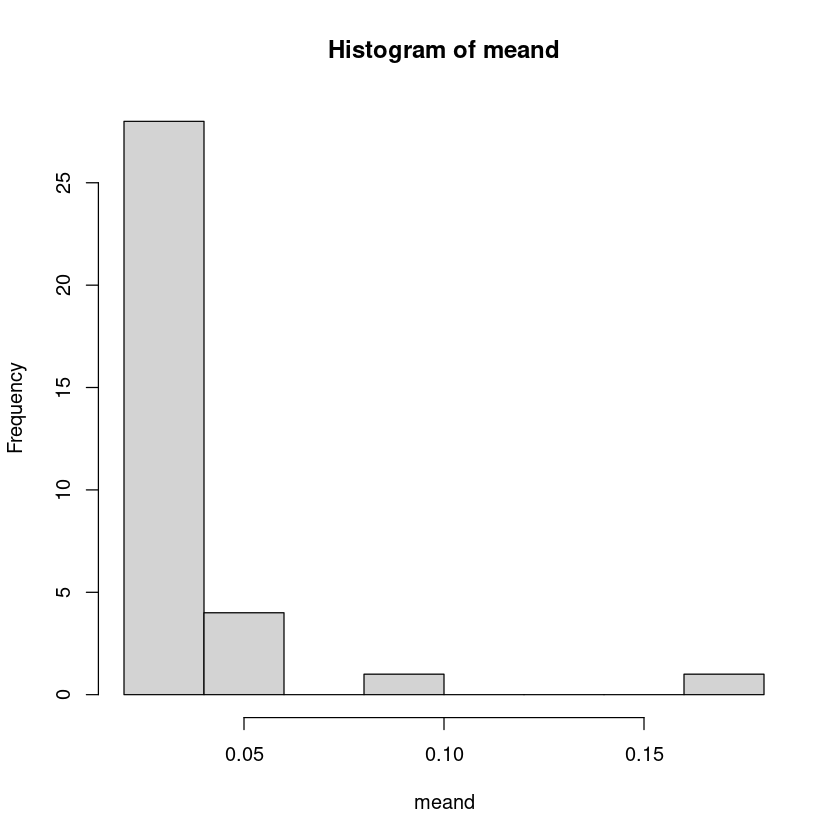

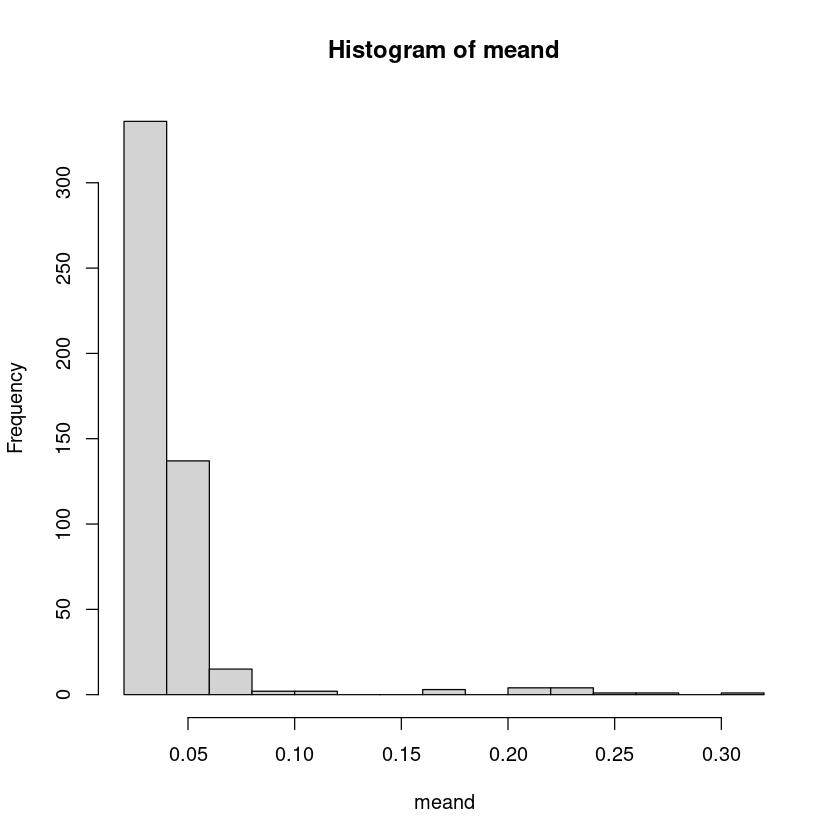

In [169]:
dists = meta %>%
    filter(!is.na(Section)) %>%
    group_by(Section) %>%
    group_map(distdendro)